# Evaluation Concrete MDD Mapping

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import math
from scipy.stats import combine_pvalues
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Data Preparation

In [2]:
csv_path = "./evaluation_dataset.csv"
df = pd.read_csv(csv_path)

print("\n=== Full Data Overview ===")
print(f"Data shape: {df.shape}")
print(df.head(5).to_string(index=False))

indicator_columns = df.columns[2:10]
feature_columns = df.columns[10:]

print("\n=== Indicator Columns ===")
for col in indicator_columns:
    print(f"- {col}")

print("\n=== Feature Columns ===")
for col in feature_columns:
    print(f"- {col}")

df_features = df.dropna(subset=feature_columns, how="all")

print("\n=== Gender Distribution (incl. NaNs) ===")
print(df_features["Gender"].value_counts(dropna=False).to_string())

print(f"\n=== Data after dropping rows with all features missing ===")
print(f"New shape: {df_features.shape}")


=== Full Data Overview ===
Data shape: (64, 35)
 Participant_ID_Disguised Gender  PHQ_8NoInterest  PHQ_8Depressed  PHQ_8Sleep  PHQ_8Tired  PHQ_8Appetite  PHQ_8Failure  PHQ_8Concentrating  PHQ_8Moving  articulation_rate     f0_avg   f0_range    f0_std  f2_transition_speed  formant_f1_frequencies_mean  glottal_pulse_rate   hnr_mean   jitter  pause_count  pause_duration        psd-4        psd-5        psd-7  rate_of_speech  rms_energy_range  rms_energy_std  shimmer      snr  spectral_flatness  spectral_modulation      t13  temporal_modulation  voice_onset_time  voiced16_20
                        1      f                0               0           0           0              0             0                   0            0           4.521739 193.940904 163.640039 30.137388            23.145779                  1663.362386          145.094440 -25.556601 0.029751     1.217391        0.830435 9.707438e-07 3.636501e-07 9.354291e-08        3.913043          0.130066        0.024539 0.148089 3

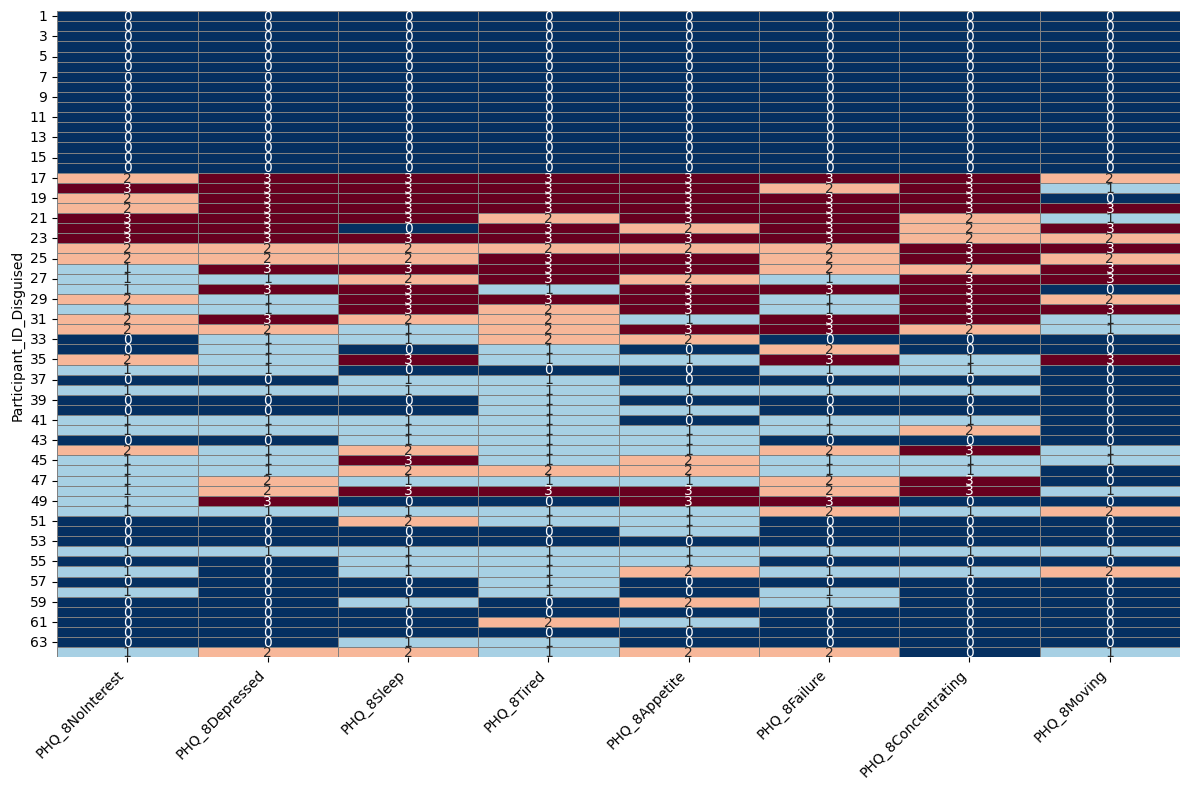

In [3]:
# Visualize the MDD DSM-5 indicator scores per participant

df_heat =  df_features.set_index("Participant_ID_Disguised")[indicator_columns]
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_heat,
    annot=True,
    fmt=".0f",
    cmap="RdBu_r",
    cbar=False,
    linewidths=0.5,
    linecolor="gray",
    vmin=0,
    vmax=3,
)
plt.ylabel("Participant_ID_Disguised", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


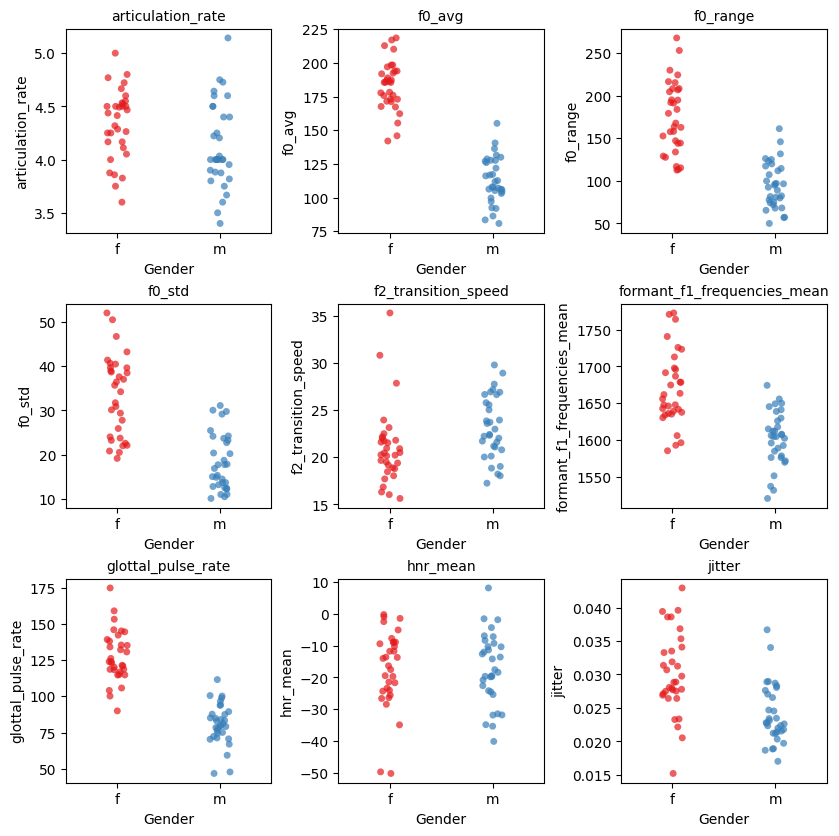

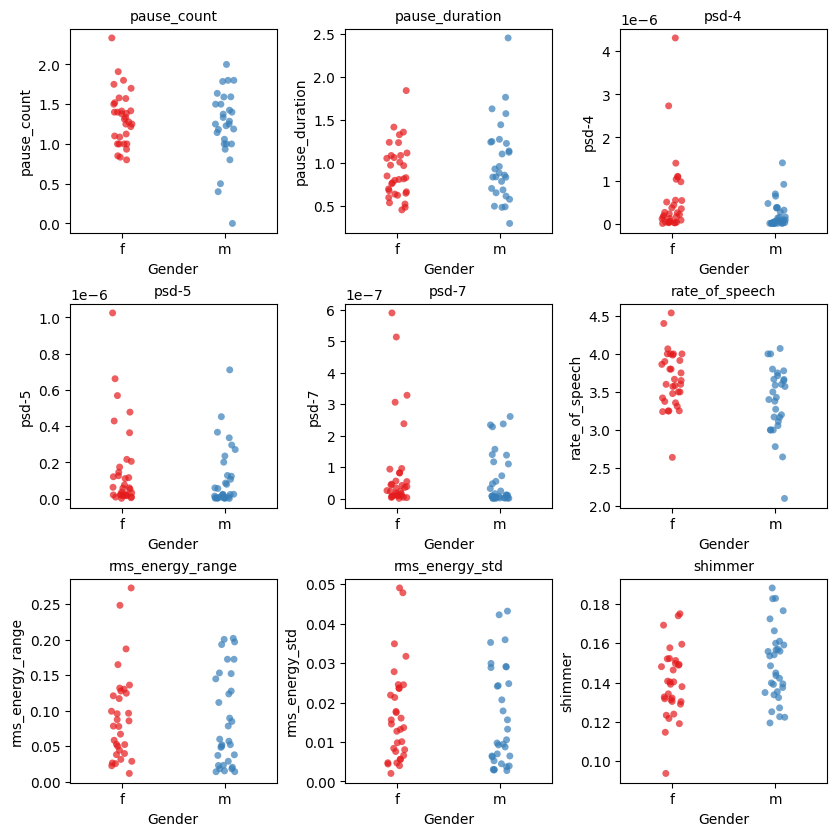

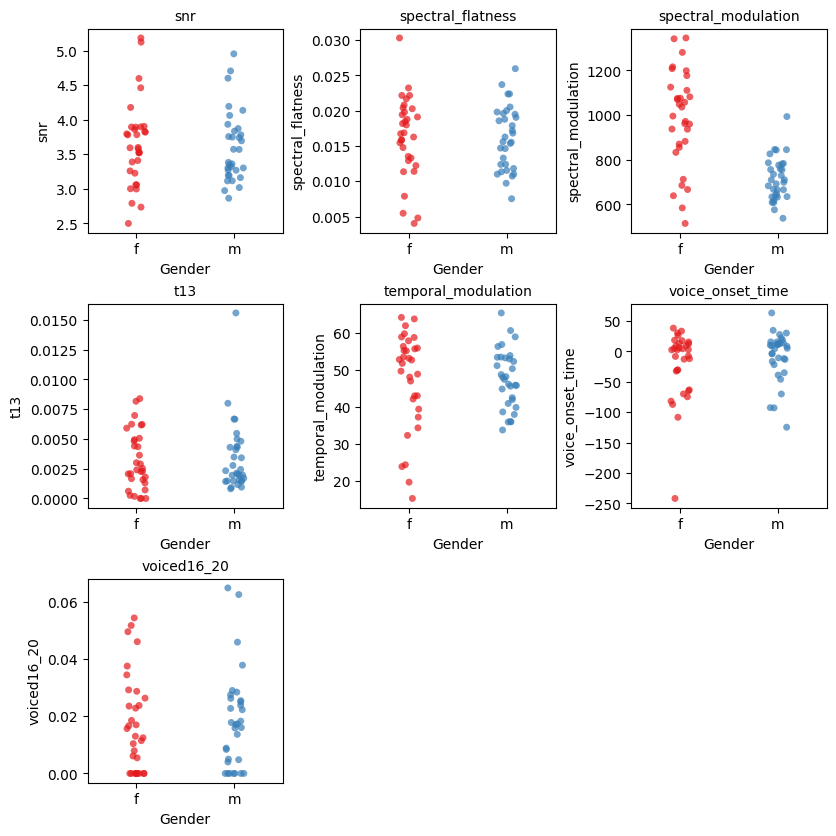

In [4]:
# Visualize the acoustic voice feature distribution per gender

features_per_plot = 9
total_features = len(feature_columns)

for plot_index in range(0, total_features, features_per_plot):
    current_features = feature_columns[plot_index : plot_index + features_per_plot]

    n_features = len(current_features)
    n_rows, n_cols = 3, 3
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 2.75, n_rows * 2.75),
        constrained_layout=True,
    )
    axes = axes.flatten()

    for i, feature in enumerate(current_features):
        sns.stripplot(
            data=df_features,
            x="Gender",
            y=feature,
            jitter=True,
            alpha=0.7,
            palette="Set1",
            ax=axes[i],
        )
        axes[i].set_title(feature, fontsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

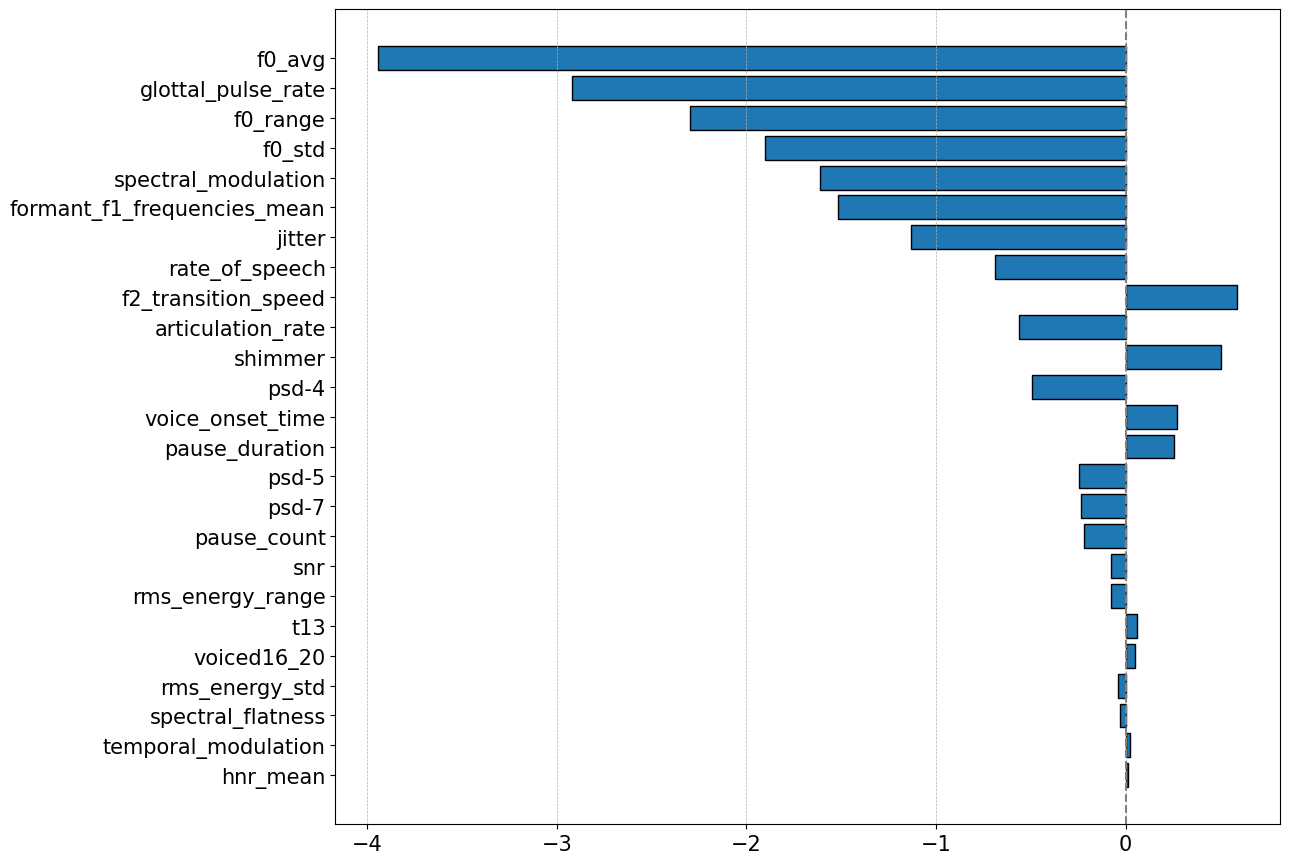

In [18]:
# Show the gender specifity of each acoustic voice feature

def cohens_d(x_male, x_female):
    mean_diff = x_male.mean() - x_female.mean()
    pooled_std = ((x_male.std() ** 2 + x_female.std() ** 2) / 2) ** 0.5
    return mean_diff / pooled_std


gender_scores = []

for feature in feature_columns:
    males = df_features[df_features["Gender"] == "m"][feature].dropna()
    females = df_features[df_features["Gender"] == "f"][feature].dropna()

    if len(males) > 1 and len(females) > 1:
        d = cohens_d(males, females)
        gender_scores.append({"feature": feature, "cohens_d": round(d, 3)})

df_gender_effects_sorted = pd.DataFrame(gender_scores).sort_values(
    "cohens_d", key=abs, ascending=True
)

plt.figure(figsize=(13, len(df_gender_effects_sorted) * 0.35))
plt.barh(
    df_gender_effects_sorted["feature"],
    df_gender_effects_sorted["cohens_d"],
    edgecolor="black",
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.grid(axis="x", linestyle="--", linewidth=0.5)
plt.show()

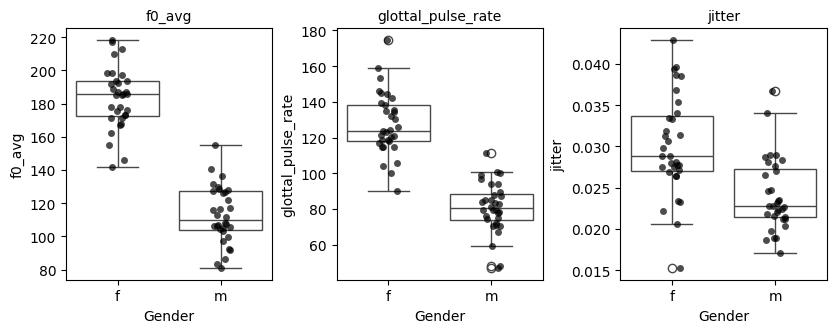

In [6]:
# Visualize a selection of gender specific acoustic voice features

selected_features = ["f0_avg", "glottal_pulse_rate", "jitter"]

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 2.75, n_rows * 2.75),
    constrained_layout=True,
)
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    ax = axes[i]
    
    sns.boxplot(
        data=df_features,
        x="Gender",
        y=feature,
        palette="Set1",
        ax=ax,
        showcaps=True,
        boxprops={"facecolor": "none"},
    )

    sns.stripplot(
        data=df_features,
        x="Gender",
        y=feature,
        jitter=True,
        alpha=0.7,
        color="black",
        ax=ax,
    )

    ax.set_title(feature, fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [7]:
# Show gender specifity groups

gender_split_features = df_gender_effects_sorted[
    df_gender_effects_sorted["cohens_d"].abs() >= 0.2
]["feature"].tolist()

gender_shared_features = df_gender_effects_sorted[
    df_gender_effects_sorted["cohens_d"].abs() < 0.2
]["feature"].tolist()

print("\n=== Gender-Split Features (|d| >= 0.2) ===")
for f in gender_split_features:
    print(f"- {f}")

print("\n=== Gender-Shared Features (|d| < 0.2) ===")
for f in gender_shared_features:
    print(f"- {f}")


=== Gender-Split Features (|d| >= 0.2) ===
- pause_count
- psd-7
- psd-5
- pause_duration
- voice_onset_time
- psd-4
- shimmer
- articulation_rate
- f2_transition_speed
- rate_of_speech
- jitter
- formant_f1_frequencies_mean
- spectral_modulation
- f0_std
- f0_range
- glottal_pulse_rate
- f0_avg

=== Gender-Shared Features (|d| < 0.2) ===
- hnr_mean
- temporal_modulation
- spectral_flatness
- rms_energy_std
- voiced16_20
- t13
- rms_energy_range
- snr


#### Define Hypotheses

In [8]:
# Here the formulated hypotheses for the evaluation are formulated.
# Note: Features that are not computed by the system and indicators that are not assessed in the dataset are not considered.

tests = [
    ("formant_f1_frequencies_mean", "PHQ_8Depressed", ">"),
    ("snr", "PHQ_8Depressed", "<"),
    ("f0_avg", "PHQ_8Depressed", "<"),
    ("f0_std", "PHQ_8Depressed", "<"),
    ("spectral_flatness", "PHQ_8Depressed", "<"),
    ("rate_of_speech", "PHQ_8Depressed", "<"),
    ("articulation_rate", "PHQ_8Depressed", "<"),
    ("pause_duration", "PHQ_8Depressed", ">"),
    ("pause_count", "PHQ_8Depressed", ">"),
    # ("VSA", "PHQ_8Depressed", "<"),
    ("f2_transition_speed", "PHQ_8Depressed", "<"),
    ("jitter", "PHQ_8Depressed", ">"),
    ("shimmer", "PHQ_8Depressed", ">"),
    ("rms_energy_range", "PHQ_8NoInterest", "<"),
    ("rms_energy_std", "PHQ_8NoInterest", "<"),
    ("f0_range", "PHQ_8NoInterest", "<"),
    ("f0_std", "PHQ_8NoInterest", "<"),
    ("jitter", "PHQ_8NoInterest", ">"),
    ("shimmer", "PHQ_8NoInterest", ">"),
    ("f0_avg", "PHQ_8Appetite", "<"),
    ("jitter", "PHQ_8Appetite", ">"),
    ("shimmer", "PHQ_8Appetite", ">"),
    ("hnr_mean", "PHQ_8Appetite", "<"),
    ("temporal_modulation", "PHQ_8Sleep", "!="),
    ("spectral_modulation", "PHQ_8Sleep", "!="),
    ("rate_of_speech", "PHQ_8Moving", "<"),
    ("articulation_rate", "PHQ_8Moving", "<"),
    ("pause_duration", "PHQ_8Moving", ">"),
    ("pause_count", "PHQ_8Moving", ">"),
    ("voice_onset_time", "PHQ_8Moving", ">"),
    ("f2_transition_speed", "PHQ_8Moving", "<"),
    ("f0_avg", "PHQ_8Moving", "<"),
    ("f0_std", "PHQ_8Moving", "<"),
    ("spectral_flatness", "PHQ_8Moving", ">"),
    # ("VSA", "PHQ_8Moving", "<"),
    ("jitter", "PHQ_8Moving", ">"),
    ("shimmer", "PHQ_8Moving", ">"),
    ("temporal_modulation", "PHQ_8Tired", "!="),
    ("spectral_modulation", "PHQ_8Tired", "!="),
    ("jitter", "PHQ_8Concentrating", ">"),
    ("shimmer", "PHQ_8Concentrating", ">"),
    ("glottal_pulse_rate", "PHQ_8Concentrating", "<"),
    ("pause_duration", "PHQ_8Concentrating", ">"),
    ("pause_count", "PHQ_8Concentrating", ">"),
    ("f0_range", "PHQ_8Concentrating", "<"),
    ("f0_std", "PHQ_8Concentrating", "<"),
    ("rms_energy_range", "PHQ_8Concentrating", "<"),
    ("rms_energy_std", "PHQ_8Concentrating", "<"),
    # ("psd-4", "Ind_9", "!="),
    # ("psd-5", "Ind_9", "!="),
    # ("psd-7", "Ind_9", "!="),
    # ("t13", "Ind_9", ">"),
    # ("voiced16_20", "Ind_9", "<"),
]

#### Evaluation

In [9]:
def test_correlation(x, y, direction=">"):
    """
    Method to test the correlation between data and labels
    with the given direction that is being tested.
    """
    
    x = x.dropna()
    y = y.dropna()
    common = x.index.intersection(y.index)

    if len(common) < 3:
        raise ValueError("Too few overlapping non-NaN values for correlation")

    x = x.loc[common]
    y = y.loc[common]

    # note for me: r is the pearson correlation coefficient
    # note for me: p is the two-tailed p-value
    # e.g.: r = 0.3, p = 0.04 means that there is a 4% change of sseing a correlation of >= 0.3 or <= -0.3 purely by change
    r, p = pearsonr(x, y)
    if direction == ">":
        p_one_tailed = p / 2 if r > 0 else 1 - (p / 2)
    elif direction == "<":
        p_one_tailed = p / 2 if r < 0 else 1 - (p / 2)
    else:
        p_one_tailed = p
    return r, p_one_tailed

In [10]:
# Compute all correlations between each feature-to-indicator pairing.

cohens_d_lookup = df_gender_effects_sorted.set_index("feature")["cohens_d"].to_dict()

all_results = []

for feature in feature_columns:
    d_value = cohens_d_lookup.get(feature, 0.0)

    for indicator in indicator_columns:
        if feature not in df_features.columns or indicator not in df_features.columns:
            all_results.append({
                "feature": feature,
                "indicator": indicator,
                "pearson_r": None,
                "p_value": None,
                "note": "Missing column"
            })
            continue

        try:

            # Note: If gender specifity is above 0.2, evaluate on the gender level and aggregate later.

            if abs(d_value) > 0.2:

                df_m = df_features[df_features["Gender"] == "m"]
                df_f = df_features[df_features["Gender"] == "f"]

                r_m, p_m = test_correlation(df_m[feature], df_m[indicator])
                r_f, p_f = test_correlation(df_f[feature], df_f[indicator])

                r_combined = (r_m + r_f) / 2
                _, p_combined = combine_pvalues([p_m, p_f])

                all_results.append({
                    "feature": feature,
                    "indicator": indicator,
                    "pearson_r": round(r_combined, 3),
                    "p_value": p_combined,
                    "note": f"Gender-split (d = {round(d_value, 3)})"
                })

            else:
                r, p = test_correlation(df_features[feature], df_features[indicator])
                all_results.append({
                    "feature": feature,
                    "indicator": indicator,
                    "pearson_r": round(r, 3),
                    "p_value": p,
                    "note": f"Combined genders (d = {round(d_value, 3)})"
                })

        except Exception as e:
            all_results.append({
                "feature": feature,
                "indicator": indicator,
                "pearson_r": None,
                "p_value": None,
                "note": f"Error: {str(e)}"
            })

df_all_results = pd.DataFrame(all_results)

valid_p = df_all_results["p_value"].dropna()
adjusted_p = multipletests(valid_p, method="fdr_bh")[1]
df_all_results.loc[df_all_results["p_value"].notnull(), "p_adjusted"] = adjusted_p
df_all_results["Significant (0.05)"] = df_all_results["p_adjusted"] < 0.05

from IPython.display import display
display(df_all_results.sort_values("pearson_r"))

,feature,indicator,pearson_r,p_value,note,p_adjusted,Significant (0.05)
63,hnr_mean,PHQ_8Moving,-0.231,0.966651,Combined genders (d = 0.015),0.966651,False
59,hnr_mean,PHQ_8Tired,-0.227,0.964378,Combined genders (d = 0.015),0.966651,False
17,f0_range,PHQ_8Depressed,-0.169,0.867633,Gender-split (d = -2.295),0.896056,False
25,f0_std,PHQ_8Depressed,-0.161,0.869175,Gender-split (d = -1.904),0.896056,False
58,hnr_mean,PHQ_8Sleep,-0.160,0.896191,Combined genders (d = 0.015),0.905244,False
...,...,...,...,...,...,...,...
74,pause_count,PHQ_8Sleep,0.204,0.016680,Gender-split (d = -0.218),0.893086,False
68,jitter,PHQ_8Appetite,0.217,0.062317,Gender-split (d = -1.132),0.893086,False
66,jitter,PHQ_8Sleep,0.261,0.034456,Gender-split (d = -1.132),0.893086,False
67,jitter,PHQ_8Tired,0.289,0.020295,Gender-split (d = -1.132),0.893086,False


#### Results

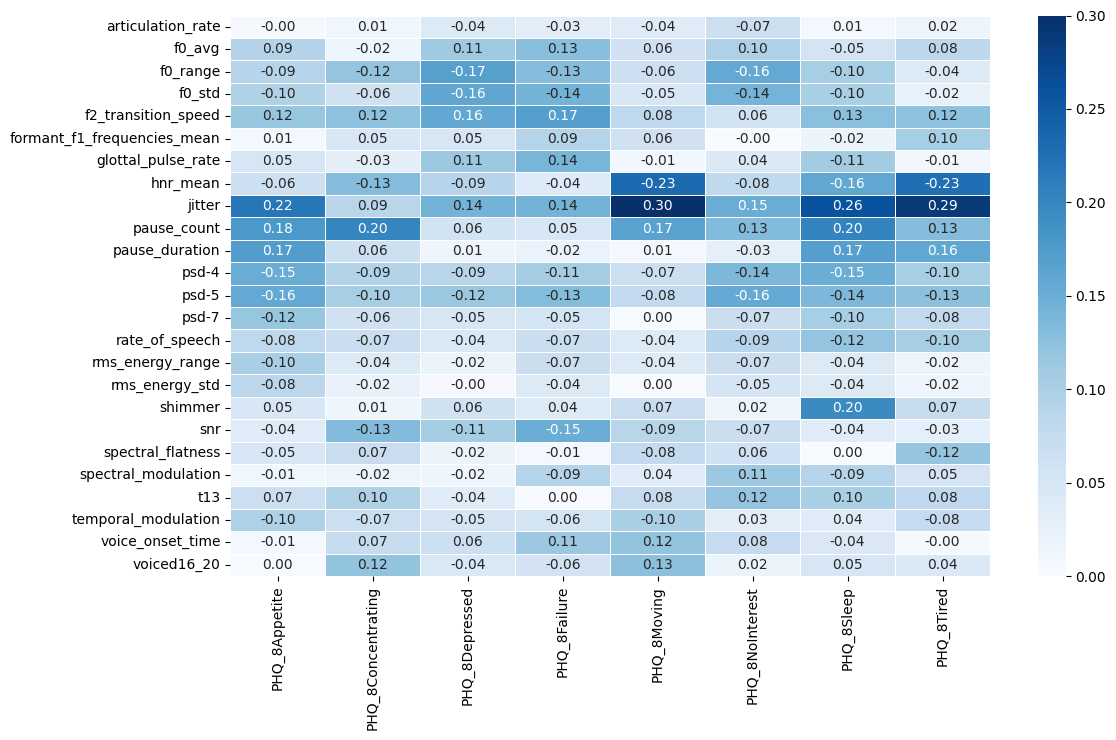

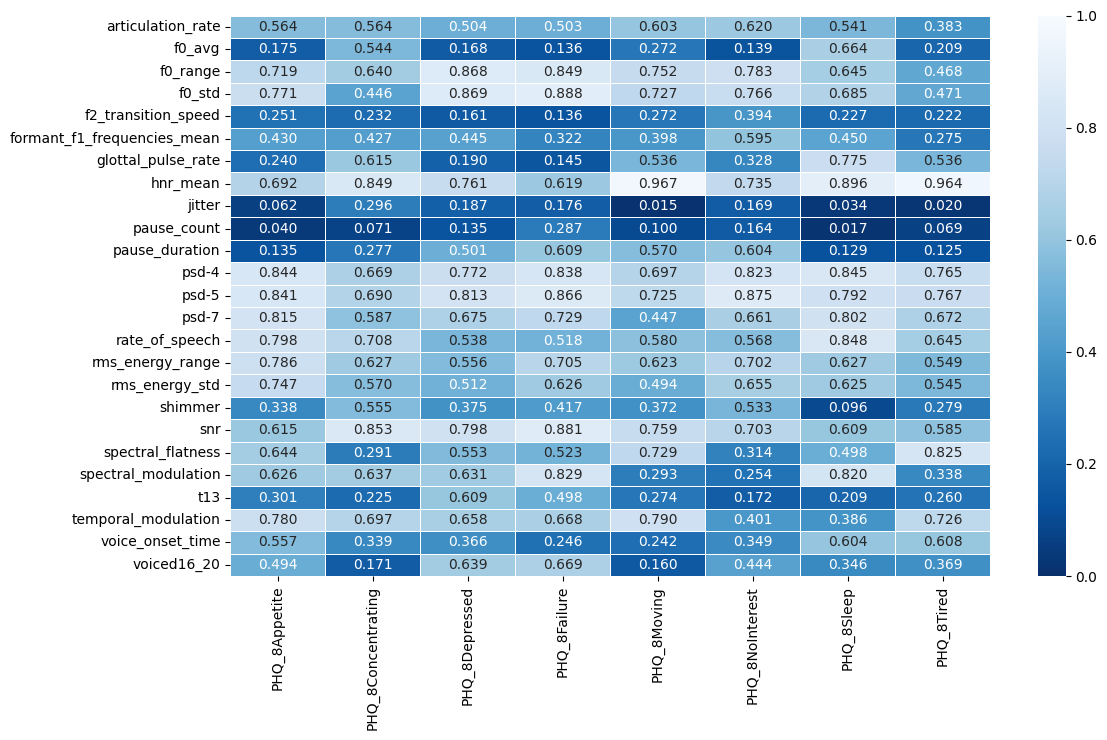

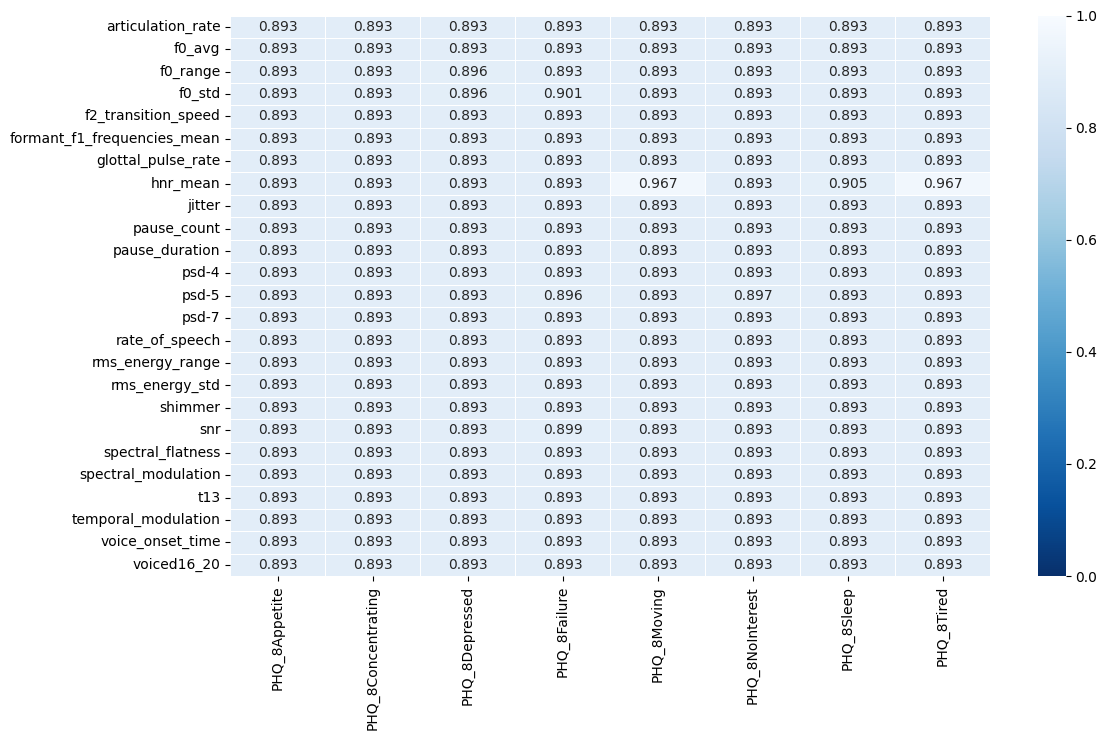

In [11]:
pivot_r = df_all_results.pivot(index="feature", columns="indicator", values="pearson_r")
pivot_p = df_all_results.pivot(index="feature", columns="indicator", values="p_value")
pivot_padj = df_all_results.pivot(index="feature", columns="indicator", values="p_adjusted")

figsize = (12, max(6, len(pivot_r) * 0.3))

pivot_r_abs = pivot_r.abs()

plt.figure(figsize=figsize)
sns.heatmap(
    pivot_r_abs,
    annot=pivot_r.round(2),
    cmap="Blues",
    fmt=".2f",
    linewidths=0.5,
    vmin=0,
    vmax=0.3
)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
sns.heatmap(pivot_p, annot=True, cmap="Blues_r", fmt=".3f", linewidths=0.5,
            vmin=0, vmax=1)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

plt.figure(figsize=figsize)
sns.heatmap(pivot_padj, annot=True, cmap="Blues_r", fmt=".3f", linewidths=0.5,
            vmin=0, vmax=1)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()